## Dog Breed Identification

In [1]:
# import modules
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [3]:
dog_files_short = train_files[:100]

In [4]:
ResNet50_model = ResNet50(weights='imagenet')

In [5]:
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [8]:
## Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_new = bottleneck_features['train']
valid_new = bottleneck_features['valid']
test_new = bottleneck_features['test']

In [9]:
### Define your architecture.
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Dense
from keras.models import Sequential
TLmodel_model = Sequential()
TLmodel_model.add(GlobalAveragePooling2D(input_shape=train_new.shape[1:]))
#TLmodel_model.add(Dense(400, activation='relu')) 
#TLmodel_model.add(Dropout(0.2))
TLmodel_model.add(Dense(200, activation='relu')) 
TLmodel_model.add(BatchNormalization())
TLmodel_model.add(Dropout(0.4))
TLmodel_model.add(Dense(133, activation='softmax'))

TLmodel_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               409800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               26733     
Total params: 437,333
Trainable params: 436,933
Non-trainable params: 400
_________________________________________________________________


In [10]:
### Compile the model.
TLmodel_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [11]:
### Train the model.
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.TLmodel_InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

TLmodel_model.fit(train_new, train_targets, 
          validation_data=(valid_new, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2, shuffle=True)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 1.12389, saving model to saved_models/weights.best.TLmodel_InceptionV3.hdf5
12s - loss: 2.4832 - acc: 0.4910 - val_loss: 1.1239 - val_acc: 0.7749
Epoch 2/20
Epoch 00001: val_loss improved from 1.12389 to 0.72002, saving model to saved_models/weights.best.TLmodel_InceptionV3.hdf5
10s - loss: 1.0255 - acc: 0.7660 - val_loss: 0.7200 - val_acc: 0.8228
Epoch 3/20
Epoch 00002: val_loss improved from 0.72002 to 0.61267, saving model to saved_models/weights.best.TLmodel_InceptionV3.hdf5
10s - loss: 0.7455 - acc: 0.8223 - val_loss: 0.6127 - val_acc: 0.8335
Epoch 4/20
Epoch 00003: val_loss improved from 0.61267 to 0.55344, saving model to saved_models/weights.best.TLmodel_InceptionV3.hdf5
9s - loss: 0.5987 - acc: 0.8522 - val_loss: 0.5534 - val_acc: 0.8407
Epoch 5/20
Epoch 00004: val_loss improved from 0.55344 to 0.53091, saving model to saved_models/weights.best.TLmodel_InceptionV3.hdf5
9s - los

In [12]:
### Load the model weights with the best validation loss.
TLmodel_model.load_weights('saved_models/weights.best.TLmodel_InceptionV3.hdf5')

In [13]:
### Calculate classification accuracy on the test dataset.
TLmodel_predictions = [np.argmax(TLmodel_model.predict(np.expand_dims(feature, axis=0))) for feature in test_new]

# report test accuracy
test_accuracy = 100*np.sum(np.array(TLmodel_predictions)==np.argmax(test_targets, axis=1))/len(TLmodel_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.6459%


In [14]:
# Write a function that takes a path to an image as input
#and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def predict_dog_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = TLmodel_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [15]:
### Write the algorithm.

def draw(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show() 
def predict_faces(img_path):
    if dog_detector(img_path):
        print('Wow, Wow you are a Dog!')
        print('And your breed is')
        print(predict_dog_breed(img_path))
        draw(img_path)
    else:
        print('Hey! You are not a Dog!! Wooooooo!! Code RED')
    return

In [16]:
## Execute the algorithm 

num_samples=6

def test_predict_breed_dog(image_index):
    print("\n")
    image_path = test_files[image_index]
    predict_faces(image_path)
    print("Correct breed is")
    print(dog_names[np.argmax(test_targets[image_index])])
    




Wow, Wow you are a Dog!
And your breed is
Golden_retriever


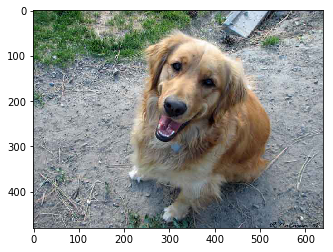

Correct breed is
Golden_retriever


Wow, Wow you are a Dog!
And your breed is
Wirehaired_pointing_griffon


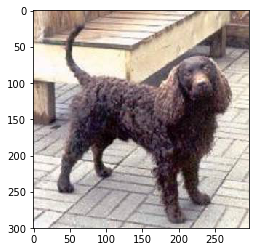

Correct breed is
American_water_spaniel


Wow, Wow you are a Dog!
And your breed is
Bernese_mountain_dog


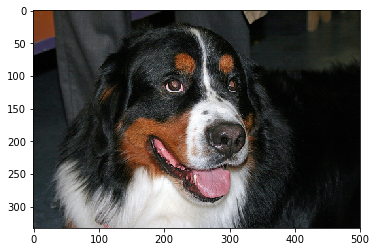

Correct breed is
Bernese_mountain_dog


Wow, Wow you are a Dog!
And your breed is
Pembroke_welsh_corgi


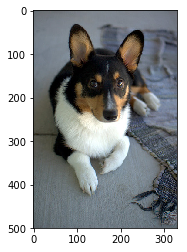

Correct breed is
Pembroke_welsh_corgi


Wow, Wow you are a Dog!
And your breed is
Gordon_setter


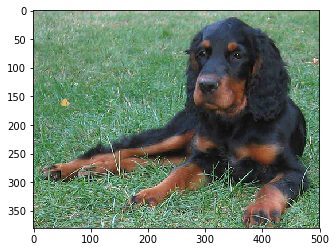

Correct breed is
Gordon_setter


Wow, Wow you are a Dog!
And your breed is
Afghan_hound


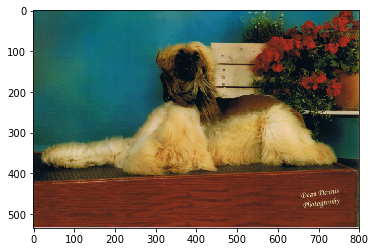

Correct breed is
Afghan_hound


[None, None, None, None, None, None]

In [17]:
# Randomly choose 5 image samples from test_files
[test_predict_breed_dog(index) for index in np.random.randint(len(test_files), size=num_samples)]